# Basic RNN - Recurrent Neural Networks
Up to now we've used neural networks to classify static images. What happens when the thing we're trying to explain changes over time? What if a predicted value depends on a series of past behaviors?

We can train networks to tell us that an image contains a car.<br>

How do we answer the question "Is the car moving? Where will it be a minute from now?"

This challenge of incorporating a series of measurements over time into the model parameters is addressed by <a href='https://en.wikipedia.org/wiki/Recurrent_neural_network'>Recurrent Neural Networks</a> (RNNs).

Be sure to watch the theory lectures. You should be comfortable with:
* conditional memory
* deep sequence modeling
* vanishing gradients
* gated cells
* long short-term memory (LSTM) cells

PyTorch offers a number of RNN layers and options.<br>
* <a href='https://pytorch.org/docs/stable/nn.html#rnn'><tt><strong>torch.nn.RNN()</strong></tt></a> provides a basic model which applies a multilayer RNN with either <em>tanh</em> or <em>ReLU</em> non-linearity functions to an input sequence.<br>
As we learned in the theory lectures, however, this has its limits.<br><br>
* <a href='https://pytorch.org/docs/stable/nn.html#lstm'><tt><strong>torch.nn.LSTM()</strong></tt></a> adds a multi-layer long short-term memory (LSTM) process which greatly extends the memory of the RNN.

## Advantages of an LSTM
For each element in the input sequence, an LSTM layer computes the following functions:<br>
$\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
    c_t = f_t * c_{(t-1)} + i_t * g_t \\
    h_t = o_t * \tanh(c_t) \\
\end{array}$

where $h_t$ is the hidden state at time $t$, <br>
$c_t$ is the cell state at time $t$, <br>
$x_t$ is the input at time $t$, <br>
$h_{(t-1)}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$, and <br>
$i_t, f_t, g_t, o_t$ are the input, forget, cell, and output gates, respectively.<br>
$\sigma$ is the sigmoid function, and $*$ is the Hadamard product.

<img style="display: inline-block" src="../Data/lstm.JPG" alt="LSTM Graphic" width="500">

To demonstrate the potential of LSTMs, we'll look at a simple sine wave. Our goal is, given a value, predict the next value in the sequence. Due to the cyclical nature of sine waves, an typical neural network won't know if it should predict upward or downward, while an LSTM is capable of learning patterns of values.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Create a sine wave dataset
For this exercise we'll look at a simple sine wave. We'll take 800 data points and assign 40 points per full cycle, for a total of 20 complete cycles. We'll train our model on all but the last cycle, and use that to evaluate our test predictions.

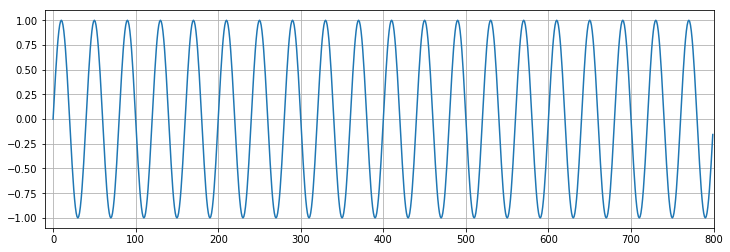

In [2]:
# Create & plot data points
x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy());

## Create train and test sets
We want to take the first 760 samples in our series as a training sequence, and the last 40 for testing.
<div class="alert alert-info"><strong>NOTE:</strong> We tend to use the terms "series" and "sequence" interchangeably. Usually "series" refers to the entire population of data, or the full time series, and "sequence" refers to some portion of it.</div>

In [3]:
test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

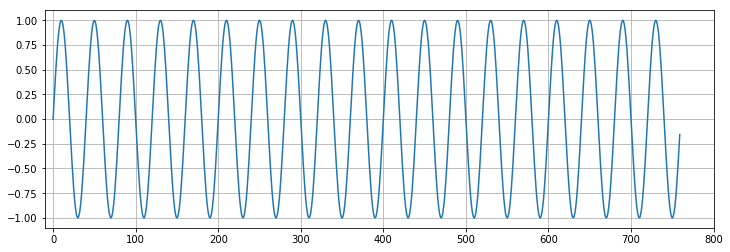

In [4]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(train_set.numpy());

## Prepare the training data
When working with LSTM models, we start by dividing the training sequence into a series of overlapping "windows". Each window consists of a connected string of samples. The label used for comparison is equal to the next value in the sequence. In this way our network learns what value should follow a given pattern of preceding values. Note: although the LSTM layer produces a prediction for each sample in the window, we only care about the last one.

For example, say we have a series of 15 records, and a window size of 5. We feed $[x_1,..,x_5]$ into the model, and compare the prediction to $x_6$. Then we backprop, update parameters, and feed $[x_2,..,x_6]$ into the model. We compare the new output to $x_7$ and so forth up to $[x_{10},..,x_{14}]$.

To simplify matters, we'll define a function called <tt>input_data</tt> that builds a list of <tt>(seq, label)</tt> tuples. Windows overlap, so the first tuple might contain $([x_1,..,x_5],[x_6])$, the second would have $([x_2,..,x_6],[x_7])$, etc. 

Here $k$ is the width of the window. Due to the overlap, we'll have a total number of <tt>(seq, label)</tt> tuples equal to $\textrm{len}(series)-k$

In [5]:
def input_data(seq,ws):  # ws is the window size
    
    # List of tuples
    out = [] # ([0,1,2,3], [4]), ([1,2,3,4], [5]) ....
    
    L = len(seq)
    
    # L-ws because we need to account for window size of ws
    # Just using L will give an index out-of-bounds error
    for i in range(L-ws):
        window = seq[i:i+ws] # [0,1,2,3]
        label = seq[i+ws:i+ws+1] # [4]
        out.append((window,label))
        
    return out

<div class="alert alert-info"><strong>NOTE:</strong> "Windows" are different from "batches". In our example we'll feed one window into the model at a time, so our batch size would be 1. If we passed two windows into the model before we backprop and update weights, our batch size would be 2.</div>

In [6]:
# From above:
# test_size = 40
# train_set = y[:-test_size]
# test_set = y[-test_size:]

window_size = 40

# Create the training dataset of sequence/label tuples:
train_data = input_data(train_set,window_size)

len(train_data) # this should equal 760-40

720

#### Explanation:
- Original train data size: 0 - 799 ---> points 
- After taking test size of 40, training data size: 800-40 ---> 760
- After breaking remaining 760 data into windows with labels: 760-40 = 720 (Look at explanation in input_data function)

In [7]:
train_data

[(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
           7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
           1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
           7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
          -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
          -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
          -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
          -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
  tensor([1.4480e-05])),
 (tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
           8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
           9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
           5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
          -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01

In [8]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [9]:
# Training data in one window
len(train_data[0][0])

40

## Define an LSTM model
Our model will have one LSTM layer with an input size of 1 and a hidden size of 50, followed by a fully-connected layer to reduce the output to the prediction size of 1.<br>
<div class="alert alert-info"><strong>NOTE:</strong> You will often see the terms <em>input_dim</em> and <em> hidden_dim</em> used in place of <em>input_size</em> and <em>hidden_size</em>. They mean the same thing. We'll stick to <em>input_size</em> and <em>hidden_size</em> to stay consistent with PyTorch's built-in keywords.</div>

During training we pass three tensors through the LSTM layer - the sequence, the hidden state $h_0$ and the cell state $c_0$.<br>

This means we need to initialize $h_0$ and $c_0$. This can be done with random values, but we'll use zeros instead.

<img style="display: inline-block" src="../Data/lstm2.JPG" alt="LSTM Graphic" width="500">

Seperate input into 2 components:
- long-term and short-term memory
- Input at time t

Same with the output:
- new long-tern and short-term memory
- Output at time t

<img style="display: inline-block" src="../Data/lstm2_eqn.JPG" alt="LSTM Graphic" width="500">

<img style="display: inline-block" src="../Data/lstm_params.JPG" alt="LSTM Graphic" width="800">

- input is the input at time t
- (h_0, c_0) is the tuple of ST memory and LT memory respectively

<img style="display: inline-block" src="../Data/lstm_outputs.JPG" alt="LSTM Graphic" width="800">

- output is the output at time t
- (h_n, c_n) is the tuple of new ST memory and new LT memory respectively

In [165]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        # input_size = no. of neurons at input layer
        # hidden_size = no. of neurons at hidden layer
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0 as tuple:
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
    
    
    # This is where we pass the actual sequence
    def forward(self,seq):
        
        # seq.view(len(seq), 1, -1) is the input
        # It's an array of 40 items since window size is 40
        # The .view is to reshape the input so it lines up correctly going into the LSTM model
        # self.hidden is the tuple (h_0, c_0)
        # lstm_out is the output
        # self.hidden is an updated tuple holding (h_n, c_n) where h_n, c_n are calculated values. Scroll up to see formula
        
        print("hidden before lstm:", self.hidden)
        print('\n')
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        
        print("h_n short_term after LSTM:", self.hidden[0][0][0])
        print('\n')
        print("c_n long_term after LSTM:", self.hidden[1][0][0])
        print('\n')
        print("hidden size after lstm:", len(self.hidden[0][0][0]), 'since there are 50 neurons in hidden layer')
        print('\n')
        print("hidden size after lstm:", len(self.hidden[1][0][0]), 'since there are 50 neurons in hidden layer')
        print('\n')
        print("seq:", seq)
        print('\n')
        print("seq reshaped:", seq.view(len(seq), 1, -1))
        print('\n')
        print("lstm_out:", lstm_out[0][0])
        print('\n')
        print("lstm_out len:", len(lstm_out[0][0]), 'output from 50 layers')
        
        # Here just feed the lstm_out (array of size 50) to get prediction for the prediction
        # pred will be a tensor of size 40
        # Reshape lstm_out before passing to linear layer 
        pred = self.linear(lstm_out.view(len(seq),-1))
        
        print('\n')
        print("pred:", pred)
        print('\n')
        print("pred.item:", pred[-1].item())
        print('\n')
        print("pred_len:", len(pred))
        return pred[-1]   # we only care about the predcition for the 41st term

## Instantiate the model, define loss & optimization functions
Since we're comparing single values, we'll use <a href='https://pytorch.org/docs/stable/nn.html#mseloss'><tt><strong>torch.nn.MSELoss</strong></tt></a><br>Also, we've found that <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.SGD'><tt><strong>torch.optim.SGD</strong></tt></a> converges faster for this application than <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><tt><strong>torch.optim.Adam</strong></tt></a>

In [173]:
torch.manual_seed(42)

model1 = LSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model1

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [174]:
def count_parameters(model):
    params = [p.numel() for p in model1.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   200
 10000
   200
   200
    50
     1
______
 10651


In [175]:
# Do 1 iteration, print the parameters and break to get a better understanding of what's going on inside this LSTM

## Predicting future values
To show how an LSTM model improves after each epoch, we'll run predictions and plot the results. Our goal is to predict the last sequence of 40 values, and compare them to the known data in our test set. However, we have to be careful <em>not</em> to use test data in the predictions - that is, each new prediction derives from previously predicted values.

The trick is to take the last known window, predict the next value, then <em>append</em> the predicted value to the sequence and run a new prediction on a window that includes the value we've just predicted. It's like adding track in front of the train as it's moving.<br><em>Image source:</em> https://giphy.com/gifs/aardman-cartoon-train-3oz8xtBx06mcZWoNJm<br>

<img style="display: inline-block" src="../Data/giphy.gif" alt="Wallace & Gromit" width="400">

In this way, a well-trained model <em>should</em> follow any regular trends/cycles in the data.

### This is just a trial run to better understand what's happening in a LSTM

In [176]:
epochs = 10
future = 40

for i in range(epochs):
    
    # tuple-unpack the train_data set
    # Seq is 40 y-values from train_data
    # y_train is the 41st value
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model1.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model1(seq)
        
        print('y_pred:', y_pred)
        print('y_train:', y_train)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
        break

        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
    # MAKE PREDICTIONS
    # start with a list of the last 40 training records
    preds = train_set[-window_size:].tolist()
    
    

    # Plot predictions
    for f in range(future):  
        # preds[-window_size:] means last 40 elements
        # convert preds to tensor and feed it to the model
        # model.hidden_size is 50
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            
            # reset the parameters and hidden states
            model1.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            
            preds.append(model(seq).item())
        break
    
    break
            

hidden before lstm: (tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]]))


h_n short_term after LSTM: tensor([ 0.0261,  0.0055, -0.0012,  0.1009, -0.0111,  0.0059,  0.0419, -0.1033,
         0.0422, -0.0764, -0.1118, -0.0666, -0.0468,  0.0653,  0.0576,  0.0384,
        -0.0152, -0.0774,  0.0424,  0.0571, -0.0106,  0.0637, -0.0360,  0.0491,
         0.1093,  0.0739,  0.1410,  0.0769,  0.0813,  0.0158, -0.1297,  0.1360,
         0.0115,  0.0196, -0.0341,  0.0541, -0.0237,  0.0373, -0.0237, -0.0576,
         0.0142,  0.0936, -0.0243,  0.0626, -0.0459, -0.0654,  0.0578, -0.0724,
  

In [146]:
y

tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
         7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
        -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,
         1.4480e-05,  1.5645e-01,  3.0903e-01,  4.5400e-01,  5.8780e-01,
         7.0712e-01,  8.0903e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5105e-01,  8.9100e-01,  8.0901e-01,
         7.0709e-01,  5.8777e-01,  4.5397e-01,  3.0900e-01,  1.5641e-01,
        -2.1005e-05, -1.5646e-01, -3.0904e-01, -4.5401e-01, -5.8780e-01,
        -7.0712e-01, -8.0903e-01, -8.9102e-01, -9.5

In [147]:
preds

[0.0002596856211312115,
 0.15669289231300354,
 0.30926769971847534,
 0.45422035455703735,
 0.5879955291748047,
 0.7072919607162476,
 0.8091720938682556,
 0.8911271691322327,
 0.9511368870735168,
 0.9877293109893799,
 1.0,
 0.9876466989517212,
 0.950973629951477,
 0.8908873796463013,
 0.8088615536689758,
 0.7069184184074402,
 0.5875681638717651,
 0.4537496268749237,
 0.3087652921676636,
 0.15617111325263977,
 -0.0002685945073608309,
 -0.1567016988992691,
 -0.30927619338035583,
 -0.4542282819747925,
 -0.5880027413368225,
 -0.7072982788085938,
 -0.8091772794723511,
 -0.8911312222480774,
 -0.9511396288871765,
 -0.9877306818962097,
 -0.9999999403953552,
 -0.9876452684402466,
 -0.9509708881378174,
 -0.8908833265304565,
 -0.8088563084602356,
 -0.706912100315094,
 -0.5875609517097473,
 -0.4537416994571686,
 -0.3087567985057831,
 -0.1561623215675354]

In [148]:
seq

tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
         7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
        -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01])

In [149]:
for seq, y_train in train_data:
    print(seq)
    print(len(seq))
    print(y_train)
    print(len(y_train))
    break

tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
         7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
        -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01])
40
tensor([1.4480e-05])
1


### Now let's do it for the whole training set

In [177]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        
        # seq.view(len(seq), 1, -1) is the input
        # It's an array of 40 items since window size is 40
        # The .view is to reshape the input so it lines up correctly going into the LSTM model
        # self.hidden is the tuple (h_0, c_0)
        # lstm_out is the output that'll be fed to the linear layer
        # self.hidden is an updated tuple holding (h_n, c_n) where h_n, c_n are calculates values. Scroll up to see formula
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        
        
        # Here just feed the lstm_out (array of size 50) to get prediction for the prediction
        # pred will be a tensor of size 40
        # Reshape lstm_out before passing to linear layer 
        
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]   # we only care about the last prediction, which is the 41st value for the previous 40 data

In [178]:
torch.manual_seed(42)

model = LSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

### Train and evaluate the model

Epoch:  1 Loss: 0.09212875
Loss on test predictions: 0.6071590185165405


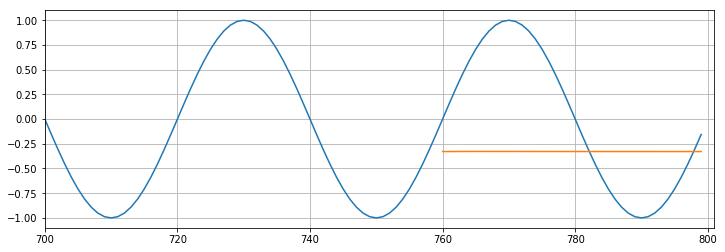

Epoch:  2 Loss: 0.06506767
Loss on test predictions: 0.565098762512207


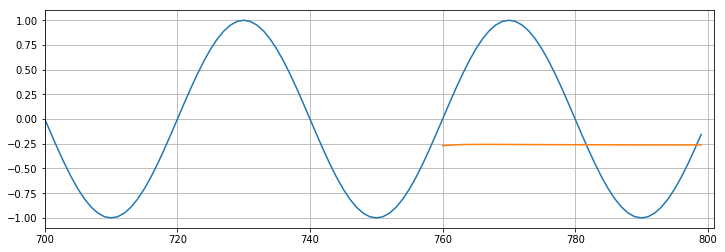

Epoch:  3 Loss: 0.04198047
Loss on test predictions: 0.5199716687202454


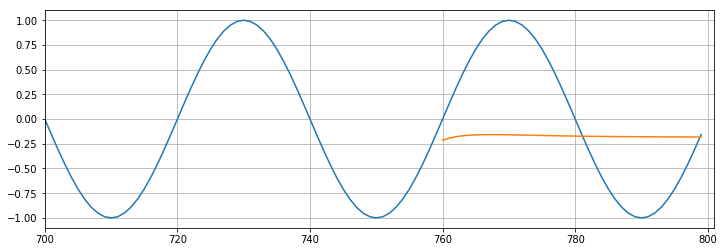

Epoch:  4 Loss: 0.01784276
Loss on test predictions: 0.42209967970848083


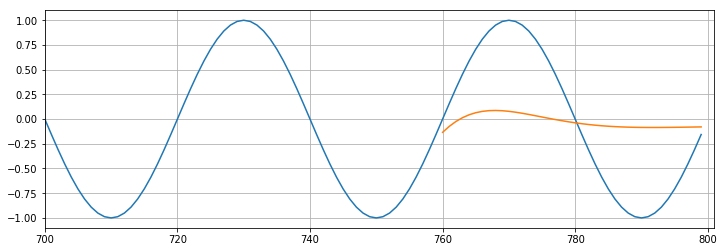

Epoch:  5 Loss: 0.00288710
Loss on test predictions: 0.16624116897583008


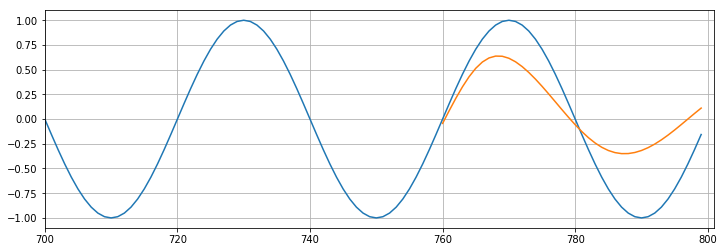

Epoch:  6 Loss: 0.00032008
Loss on test predictions: 0.03055439703166485


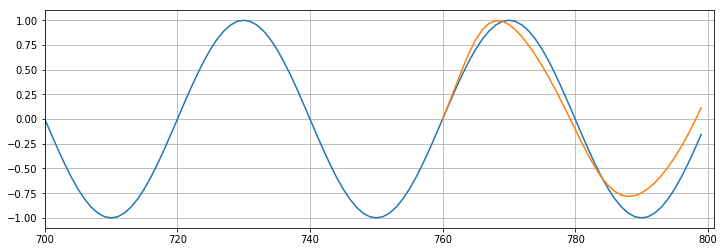

Epoch:  7 Loss: 0.00012969
Loss on test predictions: 0.014990181662142277


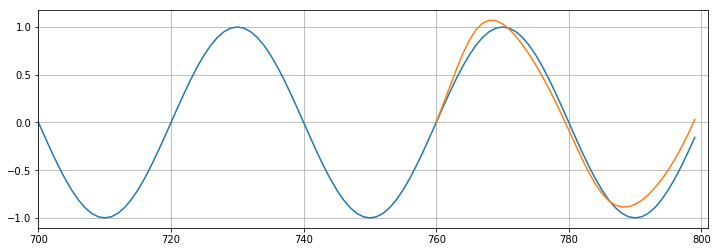

Epoch:  8 Loss: 0.00012007
Loss on test predictions: 0.011856676079332829


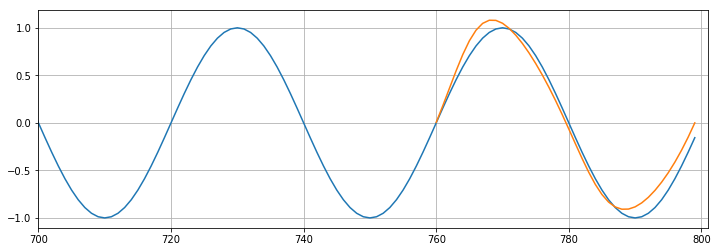

Epoch:  9 Loss: 0.00012656
Loss on test predictions: 0.010163827799260616


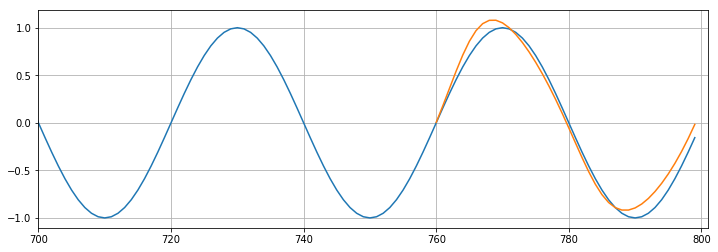

Epoch: 10 Loss: 0.00013195
Loss on test predictions: 0.00889757089316845


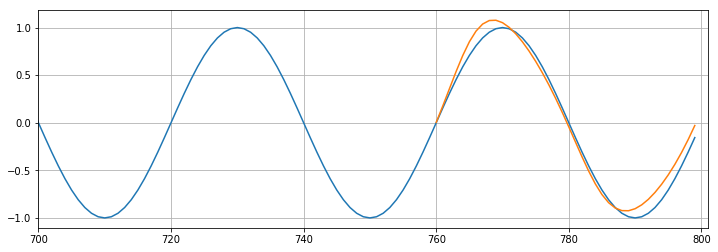

In [179]:
epochs = 10
future = 40

for i in range(epochs):
    
    # tuple-unpack the train_data set
    # Seq is 40 y-values from train_data
    # y_train is the 41st value
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
    
    # MAKE PREDICTIONS
    # start with a list of the last 40 training records. 720-760
    # This prediction will be plotted alongside actual data
    
    preds = train_set[-window_size:].tolist()

    
    for f in range(future):
        # preds[-window_size:] means last 40 elements of training set
        # convert preds to tensor and feed it to the model
        # model.hidden_size is 50
        
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            
            # reset the parameters and hidden states
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            
            # preds already has the last 40 item of the training set
            # NOTE: training set data is for the first 760
            # preds = train_set[-window_size:].tolist() took data from 720-760
            # Now we are adding predicted data for 760-800
            preds.append(model(seq).item())
            
    
    # calculate loss by comparing last 40 elements of preds and y
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

# Forecasting into an unknown future
We'll continue to train our model, this time using the entire dataset. Then we'll predict what the <em>next</em> 40 points should be. i.e 800 to 840

## Train the model
Training the model for more epochs for better fit<br>
Last time, we used a training set of 0-759 and tested for 760-800 <br>
This time, we will train the model with the full dataset 0-800

In [183]:
epochs = 15
window_size = 40
future = 40

# Create the full set of sequence/label tuples:
all_data = input_data(y,window_size)
len(all_data)  # this should equal 800-40=760

760

In [182]:
import time
start_time = time.time()

for i in range(epochs):
    
    # tuple-unpack the entire set of data
    for seq, y_train in all_data:  
       
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00013453
Epoch:  2 Loss: 0.00013443
Epoch:  3 Loss: 0.00013232
Epoch:  4 Loss: 0.00012879
Epoch:  5 Loss: 0.00012434
Epoch:  6 Loss: 0.00011931
Epoch:  7 Loss: 0.00011398
Epoch:  8 Loss: 0.00010854
Epoch:  9 Loss: 0.00010313
Epoch: 10 Loss: 0.00009784
Epoch: 11 Loss: 0.00009274
Epoch: 12 Loss: 0.00008788
Epoch: 13 Loss: 0.00008326
Epoch: 14 Loss: 0.00007890
Epoch: 15 Loss: 0.00007480

Duration: 197 seconds


## Predict future values, plot the result

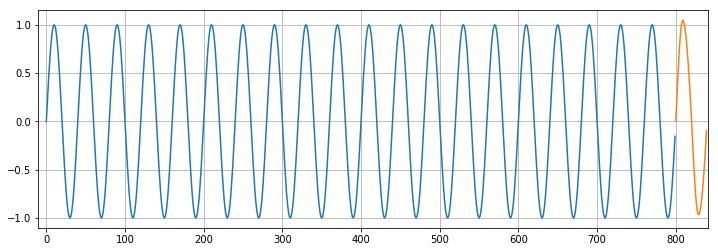

In [184]:
# 760-800
# Understand what's happening here...
# By feeding 760-800, you get prediction for 801
# Then we feed 761-801 to get prediction for 802
# Then 762-802 to get 803 
# and so... till we get prediction for 840

preds = y[-window_size:].tolist()

for i in range(future):  
    
    # seq converts the last 40 elements of preds to tensor
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size)) 
        
        # preds will be converted to tensor in the next iteration and fed back to model
        preds.append(model(seq).item())

plt.figure(figsize=(12,4))
plt.xlim(-10,841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800,800+future),preds[window_size:])
plt.show()